cuda:0
torch.Size([8, 3, 256, 256])


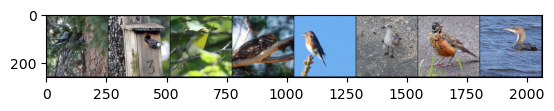

Labels:Clark's Nutcracker, White-breasted Nuthatch, Yellow-throated Vireo, Common Nighthawk, Eastern Bluebird, Laughing Gull (Nonbreeding/Immature), American Robin (Juvenile), Pacific Loon (Nonbreeding/juvenile)


Downloading: "https://github.com/pytorch/vision/zipball/v0.6.0" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 101MB/s]


Learning rate: 0.010000
[0,    10] loss: 6.470
[0,    20] loss: 6.347
[0,    30] loss: 6.116
[0,    40] loss: 5.977
[0,    50] loss: 5.772
[0,    60] loss: 5.577
[0,    70] loss: 5.390
[0,    80] loss: 5.091
[0,    90] loss: 4.955
[0,   100] loss: 4.581
[0,   110] loss: 4.497
[0,   120] loss: 4.410
[0,   130] loss: 4.180
[0,   140] loss: 4.136
[0,   150] loss: 3.906
[0,   160] loss: 3.789
[0,   170] loss: 3.718
[0,   180] loss: 3.645
[0,   190] loss: 3.604
[0,   200] loss: 3.491
[0,   210] loss: 3.446
[0,   220] loss: 3.368
[0,   230] loss: 3.100
[0,   240] loss: 3.107
[0,   250] loss: 3.060
[0,   260] loss: 2.944
[0,   270] loss: 2.941
[0,   280] loss: 2.776
[0,   290] loss: 2.864
[0,   300] loss: 2.831
[0,   310] loss: 2.693
[0,   320] loss: 2.649
[0,   330] loss: 2.519
[0,   340] loss: 2.496
[0,   350] loss: 2.522
[0,   360] loss: 2.599
[0,   370] loss: 2.477
[0,   380] loss: 2.378
[0,   390] loss: 2.504
[0,   400] loss: 2.339
[0,   410] loss: 2.341
[0,   420] loss: 2.248
[0,   430]

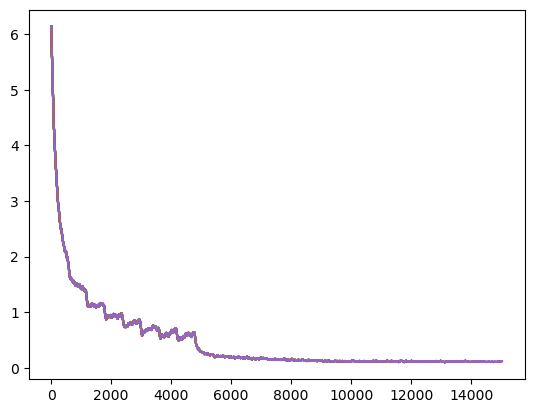

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import itertools
from torchvision.models import resnet34, ResNet34_Weights

### set up directories
prev_cpts = '/kaggle/input/checkpoint5/'
checkpoints = '/kaggle/working/'
# if not os.path.exists(checkpoints):
#     os.makedirs(checkpoints)
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')

def get_bird_data(augmentation=0, input_size=128):
    transform_train = transforms.Compose([
        transforms.Resize(input_size),
        transforms.RandomCrop(input_size, padding=8, padding_mode='edge'), # Take 128x128 crops from padded images
        transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
#         transforms.RandomVerticalFlip(),
#         transforms.ColorJitter(0.5, 0.5, 0.5, 0.5),
        transforms.ToTensor(),
    ])
    
    transform_test = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
    ])
    
    

    data_path = '/kaggle/input/birds23sp/birds/'

    trainset = torchvision.datasets.ImageFolder(root=data_path + 'train', transform=transform_train)
    testset = torchvision.datasets.ImageFolder(root=data_path + 'test', transform=transform_test)
    
    trainset_small = torch.utils.data.Subset(trainset, range(0,1400))
    testset_small = torch.utils.data.Subset(trainset, range(0,600))
    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)
    
    
    
    classes = open(data_path + "names.txt").read().strip().split("\n")
    class_to_idx = trainset.class_to_idx
    idx_to_class = {int(v): int(k) for k, v in class_to_idx.items()}
    idx_to_name = {k: classes[v] for k,v in idx_to_class.items()}
    return {'train': trainloader, 'test': testloader, 'to_class': idx_to_class, 'to_name':idx_to_name}

def train(net, dataloader, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005, 
          verbose=1, print_every=10, state=None, schedule={}, checkpoint_path=None):
    net.to(device)
    net.train()
    losses = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
    #optimizer = optim.RMSprop(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)

    # Load previous training state
    if state:
        net.load_state_dict(state['net'])
        optimizer.load_state_dict(state['optimizer'])
        start_epoch = state['epoch']
        losses = state['losses']

    # Fast forward lr schedule through already trained epochs
    for epoch in range(start_epoch):
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

    for epoch in range(start_epoch, epochs):
        sum_loss = 0.0

        # Update learning rate when scheduled
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

        for i, batch in enumerate(dataloader, 0):
            inputs, labels = batch[0].to(device), batch[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # autograd magic, computes all the partial derivatives
            optimizer.step() # takes a step in gradient direction

            losses.append(loss.item())
            sum_loss += loss.item()

            if i % print_every == print_every-1:    # print every 10 mini-batches
                if verbose:
                  print('[%d, %5d] loss: %.3f' % (epoch, i + 1, sum_loss / print_every))
                sum_loss = 0.0
        if checkpoint_path:
            state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses}
            torch.save(state, checkpoint_path + 'checkpoint-%d.pkl'%(epoch+1))
            plt.plot(smooth(state['losses'], 50))
            plt.savefig('checkpoint-%d.png'%(epoch+1))
    return losses

data = get_bird_data(input_size=256)
# print(len(data['to_name']))
# print(data['to_name'])

dataiter = iter(data['train'])
images, labels = next(dataiter)
images = images[:8]
print(images.size())

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("Labels:" + ', '.join('%9s' % data['to_name'][labels[j].item()] for j in range(8)))

resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet34', weights=ResNet34_Weights.IMAGENET1K_V1)
resnet.fc = nn.Linear(512, 555) # This will reinitialize the layer as well

# resnet = torchvision.models.resnet18(pretrained=True)
# resnet.fc = nn.Linear(2048, 555) # This will reinitialize the layer as well

if (0):
    state = torch.load(prev_cpts + 'checkpoint-8.pkl')
    resnet.load_state_dict(state['net'])
    losses = train(resnet, data['train'], epochs=12, schedule={0:.01, 6:.001}, lr=.01, print_every=10, checkpoint_path=checkpoints, state=state)
else: 
    losses = train(resnet, data['train'], epochs=25, schedule={0:.01, 8:.001, 15:0.0001}, lr=.01, print_every=10, checkpoint_path=checkpoints)

    
# cp /kaggle/input/checkpoint5/checkpoint-5.pkl /kaggle/working
